In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsa.ts_utils import * 
from scripts.python.tsa.utsmodel import * 
from scripts.python.tsa.mtsmodel import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = os.getcwd() + "/data/tourism/tonga/intermediate/"
filepath = [folder + file for file in os.listdir(folder) if ".csv" in file]

## SARIMAX

,date,yacht,all,total,ship,stringency_index,covid,tonga_flights,tonga_hotel,tonga_travel
0,2010-01-01,4,3808,3158,646,0.0,0.0,1.118195,1.296399,0.212187
1,2010-02-01,5,2384,2379,0,0.0,0.0,0.811451,1.013375,0.480398
2,2010-03-01,5,3992,3134,853,0.0,0.0,0.872967,1.359485,0.233651
3,2010-04-01,30,5650,2818,2802,0.0,0.0,0.583649,1.142021,0.400232
4,2010-05-01,177,9150,3670,5303,0.0,0.0,0.906579,1.746620,0.749327


training size : 144, testing size : 0
THE BENCHMARK EVALUATION FOR TONGA 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TONGA 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1189.192
Date:                            Wed, 14 Jun 2023   AIC                           2394.384
Time:                                    16:24:11   BIC                           2418.087
Sample:                                         0   HQIC                          2404.016
                                            - 144                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

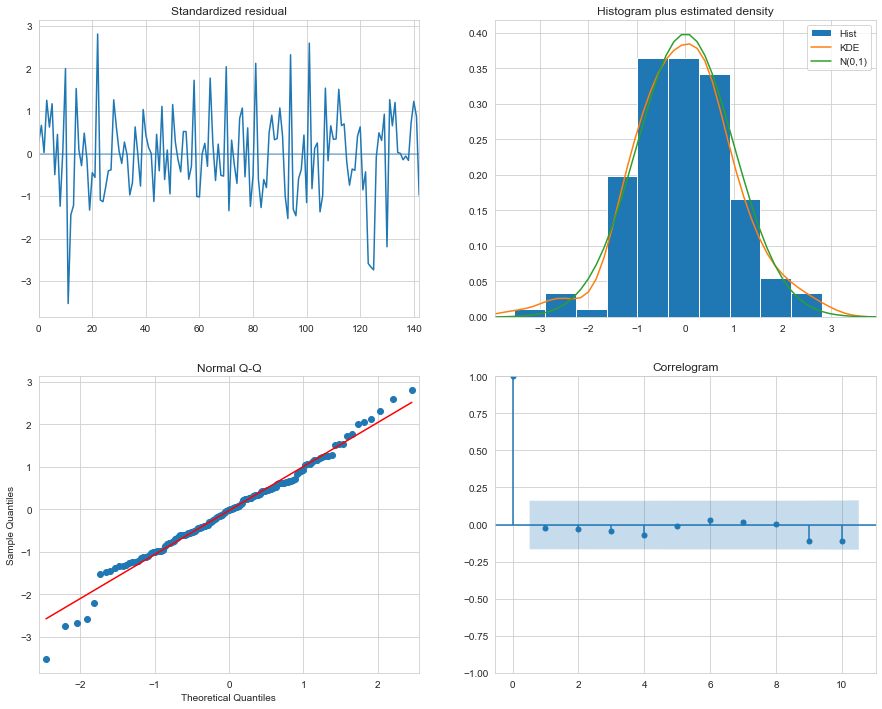

STARTED TO CONDUCT GRID SEARCHING FOR TONGA 

LU decomposition error.
LU decomposition error.
STARTED TO CONDUCT CROSS-VALIDATION FOR TONGA 

Best Models from Cross-validation is  ARIMA(1,0,2)(0,1,1)[12] intercept 



,MSE,RMSE,MAE,SMAPE
naive,2.543522e+06,1594.842251,1043.874126,35.445486
mean,4.529700e+06,2128.309258,1637.978395,53.528230
seasonal naive,4.760284e+06,2181.807619,1256.819444,53.730230
SARIMAX,inf,inf,inf,151.983762


In [3]:
countries = ["tonga"]
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

for country in countries:

    mod = SARIMAXPipeline(country=country, y_var="total",
                          data=None,
                          exog_var=["covid", "stringency_index",
                                    str(country)+"_travel"],
                          transform_method=None,
                          training_ratio=1,
                          verbose=False)
    mod.read_and_merge()
    display(mod.data.head(5))
    
    
    mod.transform()
    print(f"The Benchmark Evaluation for {country}".upper(), "\n")
    mod.get_benchmark_evaluation()
    print(f"Started to conduct stepwise searching for {country}".upper(), "\n")
    mod.stepwise_search()

    print(f"Started to conduct Grid searching for {country}".upper(), "\n")
    mod_msres = mod.manual_search(params=all_param)
    mod_msres.sort(key=lambda x: x[1])

    mod_swm = mod.stepwise_model
    if mod_msres[0][-1] == (mod_swm["order"], mod_swm["seasonal_order"]):
        print(mod_msres[0][-1])
    else:
        cv_models = []
        cv_models.append(pm.ARIMA(
            mod_swm["order"], mod_swm["seasonal_order"],  exog=mod.exog[:mod.training_size]))

        # Append top five GridSearch results
        for res in mod_msres[:5]:
            order, seasonal_order = res[-1]
            model = pm.ARIMA(order, seasonal_order,
                             exog=mod.exog[:mod.training_size])
            cv_models.append(model)

        print(
            f"Started to conduct Cross-validation for {country}".upper(), "\n")
        mod_cv_comp = mod.compare_models(
            y=mod.transformed_y, exog=mod.exog, models=cv_models)
        best_cv_idx = np.nanargmin(mod_cv_comp["avg_error"])
        print(
            f"Best Models from Cross-validation is {cv_models[best_cv_idx]}", "\n")

        if best_cv_idx > 0:
            best_mod = mod_msres[best_cv_idx-1][0]
            best_mod_pred = mod.get_prediction_df(
                best_mod, mod.test_size, mod.exog[-mod.test_size:])

        

In [7]:
# Merge the prediction with actual values
best_mod_pred.columns.name = None
best_mod_pred = pd.concat(
    [mod.data[["date", "total"]], best_mod_pred], axis=1)

if mod.test_size != 0:
    pred_series = (best_mod_pred["train_pred"].fillna(0)
                   + best_mod_pred["test_pred"].fillna(0))
else:
    pred_series = best_mod_pred["train_pred"]

mod_eval = (pd.DataFrame(calculate_evaluation(
    best_mod_pred["total"], pred_series), index=["SARIMAX"]))
mod_eval = pd.concat([mod.benchmark, mod_eval], axis=0)
display(mod_eval)

,MSE,RMSE,MAE,SMAPE
naive,2.543522e+06,1594.842251,1043.874126,35.445486
mean,4.529700e+06,2128.309258,1637.978395,53.528230
seasonal naive,4.760284e+06,2181.807619,1256.819444,53.730230
SARIMAX,1.643648e+06,1282.048475,821.669825,50.100220


,date,yacht,all,total,ship,stringency_index,covid,tonga_flights,tonga_hotel,tonga_travel
0,2010-01-01,4,3808,3158,646,0.0,0.0,1.118195,1.296399,0.212187
1,2010-02-01,5,2384,2379,0,0.0,0.0,0.811451,1.013375,0.480398
2,2010-03-01,5,3992,3134,853,0.0,0.0,0.872967,1.359485,0.233651
3,2010-04-01,30,5650,2818,2802,0.0,0.0,0.583649,1.142021,0.400232
4,2010-05-01,177,9150,3670,5303,0.0,0.0,0.906579,1.746620,0.749327


training size : 144, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(4, 1, 1)x(2, 0, [], 12)   Log Likelihood                -195.227
Date:                             Wed, 14 Jun 2023   AIC                            412.454
Time:                                     16:53:40   BIC                            445.045
Sample:                                          0   HQIC                           425.697
                                             - 144                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

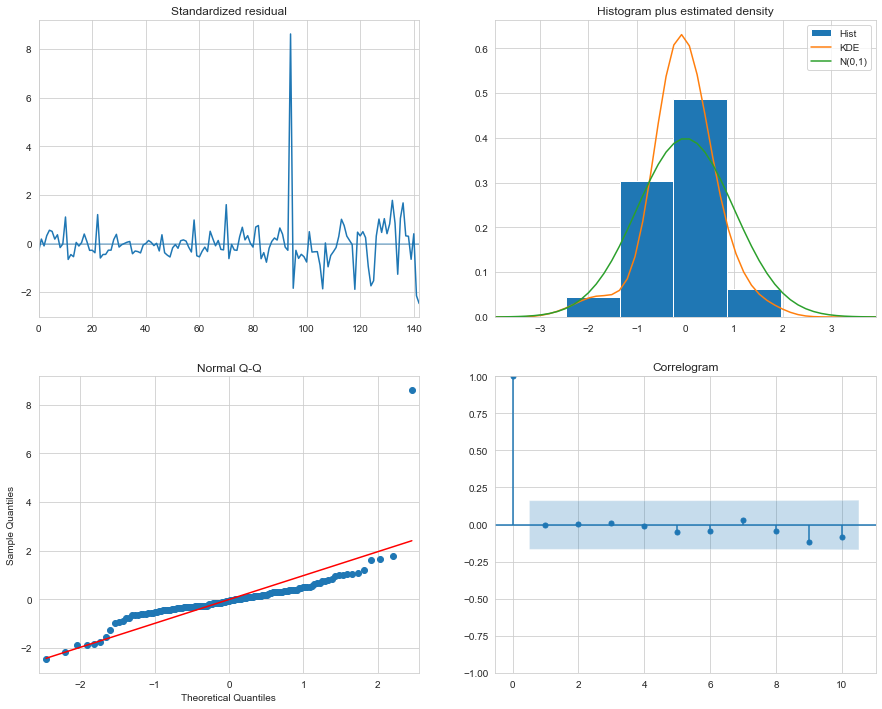

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(1,0,0)(0,1,1)[12] intercept 



In [9]:
from sarimaxs import run_sarimax
tg_no_gt = run_sarimax(country="tonga", y_vars=["total"], method="scaledlogit",
                    exog_var=["covid", "stringency_index"])

In [10]:
calculate_evaluation(tg_no_gt["total"], tg_no_gt["total_pred"])

{'MSE': 756194.3098542134,
 'RMSE': 869.5943363742737,
 'MAE': 563.1014123439359,
 'SMAPE': 30.119477738642953}

## Ratio


TONGA's Official and Avaition Data.

 Create Loaded Factor for TONGA:

 Regression TONGA:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.939
Model:                            WLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     65.47
Date:                Mon, 22 May 2023   Prob (F-statistic):           1.99e-16
Time:                        16:56:32   Log-Likelihood:                 45.748
No. Observations:                  38   AIC:                            -75.50
Df Residuals:                      30   BIC:                            -62.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.318781,4688,14706.0,0.598405,0.036987,0.522867,0.673944,0.415241,0.781570,8800.151241
1,2019-02-01,0.632136,6157,9740.0,0.597249,0.035485,0.524779,0.669719,0.415329,0.779170,5817.208714
2,2019-03-01,0.848574,8686,10236.0,0.595672,0.034303,0.525617,0.665728,0.414700,0.776644,6097.302982
3,2019-04-01,0.725765,7704,10615.0,0.642278,0.040534,0.559496,0.725061,0.456010,0.828547,6817.786091
4,2019-05-01,0.573453,6800,11858.0,0.637493,0.034155,0.567738,0.707247,0.456637,0.818348,7559.386306


,MSE,RMSE,MAE,SMAPE
mean,1.368747e+07,3699.657587,3432.540166,154.297982
naive,1.776518e+06,1332.860792,647.945946,63.764255
ratio,8.925660e+05,944.757125,414.524955,98.318381


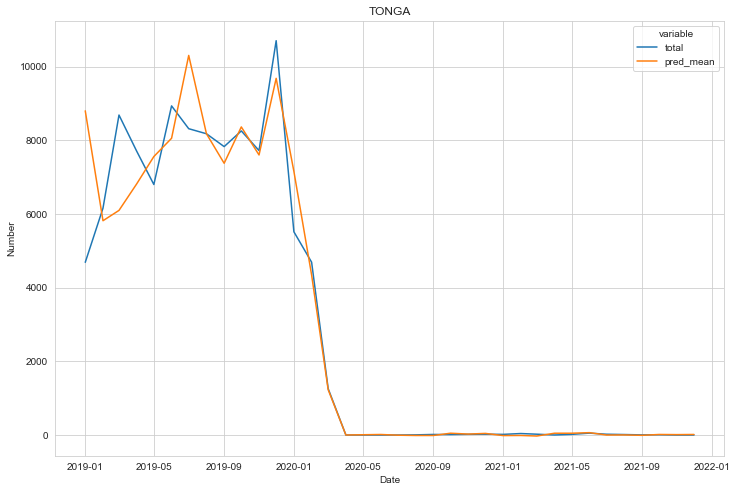

In [34]:
country = "tonga"
mod = RatioPipe(country=country, data=None)
print(f"\n{country.upper()}'s Official and Avaition Data.")
mod.read_and_merge()

print(f"\n Create Loaded Factor for {country.upper()}:")
mod.transform()

print(f"\n Regression {country.upper()}:")
mod.fit()
pred_df = mod.get_prediction_df()

mean_pred, naive_pred = \
    mean_method(pred_df["total"]), naive_method(pred_df["total"])

benchmark = pd.DataFrame()
eval_name = ["mean", "naive", "ratio"]
for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
    eval_df = pd.DataFrame(calculate_evaluation(
        pred_df["total"], pred), index=[idx])
    benchmark = pd.concat([benchmark, eval_df])
display(benchmark)

ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
plt.show()

In [35]:
gt = mod.read_trends_data()
gt.columns = [col.replace(" ", "_") for col in gt.columns]
tonga_si = mod.read_covid_data()

In [36]:
tonga_si = (tonga_si[tonga_si.date >="2022-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (tonga_si.merge(
    gt[["date", "tonga_flights", "tonga_travel"]],
    how="left", on="date"))
temp_fu["covid"] = (temp_fu.date >= "2020-03-12").astype(int)
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu = temp_fu.dropna() 

In [37]:
uni_future = (best_mod.get_forecast(
    exog=temp_fu[["covid", "stringency_index", "tonga_travel"]],
    steps=len(temp_fu))
    .summary_frame())
uni_future.columns.name = None
for col_idx, col in enumerate(uni_future.columns):
    for row_idx, _ in enumerate(uni_future[col]):
        uni_future.iloc[row_idx, col_idx] = inverse_scaledlogit(
            uni_future.iloc[row_idx, col_idx], upper, lower)

uni_future = (uni_future.reset_index()
              .drop("index", axis=1))
uni_future.columns = [col.replace("mean", "uni") for col in uni_future.columns]
uni_future["date"] = temp_fu["date"]
uni_future.head(5)

,uni,uni_se,uni_ci_lower,uni_ci_upper,date
0,0.409749,9735.195148,-0.805825,9.229172,2022-01-01
1,1.790042,9774.104124,-0.626834,19.835668,2022-02-01
2,2.116490,9825.758613,-0.599288,23.204611,2022-03-01
3,3.601353,9830.979837,-0.410678,34.853027,2022-04-01
4,6.912003,9833.603863,0.011515,60.668479,2022-05-01


In [38]:
future = mod.res.get_prediction(temp_fu).summary_frame()
future["date"] = temp_fu["date"]
future

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date
0,-0.088819,0.276504,-0.653516,0.475877,-0.677653,0.500015,2022-01-01
1,-0.028646,0.046413,-0.123435,0.066142,-0.220552,0.163260,2022-02-01
2,-0.025174,0.042446,-0.111861,0.061513,-0.213211,0.162863,2022-03-01
3,0.023071,0.030075,-0.038351,0.084493,-0.154737,0.200880,2022-04-01
4,0.021434,0.040086,-0.060432,0.103300,-0.164429,0.207297,2022-05-01
5,0.034123,0.042247,-0.052157,0.120402,-0.153726,0.221972,2022-06-01
6,0.014680,0.053406,-0.094389,0.123749,-0.184667,0.214027,2022-07-01
7,0.006408,0.071798,-0.140224,0.153040,-0.215727,0.228543,2022-08-01
8,0.014572,0.062108,-0.112269,0.141414,-0.195027,0.224172,2022-09-01
9,0.043734,0.066540,-0.092158,0.179627,-0.171463,0.258932,2022-10-01


In [39]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

tg_avi = (aviation[(aviation.ISO == "TO") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
tg_avi["Date"] = pd.to_datetime(tg_avi["Date"])
tg_avi["Month"], tg_avi["Year"] = tg_avi["Date"].dt.month, tg_avi["Date"].dt.year
tg_avi = tg_avi.groupby(["Year", "Month"]).sum().reset_index()
tg_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(tg_avi.Year, tg_avi.Month)]
tg_avi["date"] = pd.to_datetime(tg_avi["date"])
tg_avi_future = tg_avi[tg_avi.date >= "2022-01-01"].reset_index().drop("index", axis=1)
tg_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2022,1,1093,1093,2022-01-01
1,2022,2,1525,1525,2022-02-01
2,2022,3,2410,2410,2022-03-01
3,2022,4,1726,1726,2022-04-01
4,2022,5,1464,1464,2022-05-01


In [40]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "lf")
        future[colname] = tg_avi_future["Seats_arrivals_intl"] * future[col]
future.head(5)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,lf,lf_ci_lower,lf_ci_upper
0,-0.088819,0.276504,-0.653516,0.475877,-0.677653,0.500015,2022-01-01,-97.079573,-714.292936,520.133790
1,-0.028646,0.046413,-0.123435,0.066142,-0.220552,0.163260,2022-02-01,-43.685466,-188.237869,100.866937
2,-0.025174,0.042446,-0.111861,0.061513,-0.213211,0.162863,2022-03-01,-60.669182,-269.584645,148.246280
3,0.023071,0.030075,-0.038351,0.084493,-0.154737,0.200880,2022-04-01,39.820658,-66.194226,145.835542
4,0.021434,0.040086,-0.060432,0.103300,-0.164429,0.207297,2022-05-01,31.379354,-88.471947,151.230655


In [41]:
forecast = future.iloc[:, -4:]
forecast = forecast.merge(uni_future)
forecast

,date,lf,lf_ci_lower,lf_ci_upper,uni,uni_se,uni_ci_lower,uni_ci_upper
0,2022-01-01,-97.079573,-714.292936,520.133790,0.409749,9735.195148,-0.805825,9.229172
1,2022-02-01,-43.685466,-188.237869,100.866937,1.790042,9774.104124,-0.626834,19.835668
2,2022-03-01,-60.669182,-269.584645,148.246280,2.116490,9825.758613,-0.599288,23.204611
3,2022-04-01,39.820658,-66.194226,145.835542,3.601353,9830.979837,-0.410678,34.853027
4,2022-05-01,31.379354,-88.471947,151.230655,6.912003,9833.603863,0.011515,60.668479
5,2022-06-01,76.810187,-117.404414,271.024787,12.818822,9834.053797,0.766752,106.420023
6,2022-07-01,42.661383,-274.293127,359.615893,24.609629,9834.194421,2.276406,196.904869
7,2022-08-01,31.719248,-694.107964,757.546460,29.699350,9834.197769,2.928872,235.626116
8,2022-09-01,87.740455,-675.972781,851.453692,15.714101,9833.910505,1.137558,128.720373
9,2022-10-01,152.020215,-320.341702,624.382133,119.613462,9833.694479,14.533905,887.863708
